# Hands-on tutorial: The three-point correlation function $g_3$

- **Notebook: Analysis of an fcc structure demonstrating the three-point correlation function $g_3$**

<hr>

- Material for the Erice [7th Workshop and School on Frontiers in Water Biophysics (FWB)](https://www.waterbiophysics.eu/Main/HomePage)
- EuMINe Training School on Machine Learning in Hydrated Biosystems.
- Sunday, July 6, 2025, Erice, Sicily, Italy.
  - Lecture: 8:45-9:55
  - Hands-on session: 14:45-15:45 (16:05)
- Material by [Mikko Karttunen](https://www.softsimu.net/mikko/) and [Matt Davies](https://www.researchgate.net/profile/Matthew-Davies-48). If using the codes here, please cite the two articles below:
  - The $g_3$ three-point correlation function was originally introduced in: Sukhomlinov, S. V.; Müser, M. H. A Mixed Radial, Angular, Three-Body Distribution Function as a Tool for Local Structure Characterization: Application to Single-Component Structures. [J. Chem. Phys. 2020, 152, 194502](https://doi.org/10.1063/5.0007964).
  - It was further worked on, and integrated to an ML workflow in:  Davies, M.; Reyes-Figueroa, A. D.; Gurtovenko, A. A.; Frankel, D.; Karttunen, M. Elucidating Lipid Conformations in the Ripple Phase: Machine Learning Reveals Four Lipid Populations. [Biophys. J. 2023, 122, 442–450](https://doi.org/10.1016/j.bpj.2022.11.024).

<hr>

## Workflow and approach in this hands-on

To demonstrate the $g_3$ three-point correlation function, we first analyze simple systems of fcc (face-centered cubic) crystals of copper. We start with a lattice system to get a better feel of what $g_3$ does and how it relates to the usual $g(r)$.

Some basic properties of Cu:
- Crystal structure: face-centered cubic (fcc)
- Lattice constant: $a \approx 0.3615\,\mathrm{nm}$
- Atoms per unit cell: 4
- Coordination number: 12
- Atomic packing factor: 0.740
- Metals with fcc packing: Cu, Pb, Al

The figure below (from Wikipedia, [copper](https://en.wikipedia.org/wiki/Copper)) shows an fcc structure and the lattice constant.

![alt text](./pics/fcc_structure.svg)

Since we have a single frame for this system, the analyzes are very quick - for a realistic size systems of >10's of thousands of atoms and, perhaps, millions of frames, the analyzes can easily take hours or even days. 

**Workflow:**
```
Load trajectory & topology
  -> make atom 3 selections: reference (the central atom), neighour, and the rest (target)
    -> run g3 over the trajectory (or selected frames; in this example a single frame) and average
       -> plot the results
```

### Important: Before you start:

1. It assumed that (based on the other set of notes), that you have cloned the github directory and successfully installed `MDAnalysis`.
2. We will read in the topology and trajectory files, and demonstrate some of the capabilities of `MDAnalysis` by extracting and printing out trajectory and system information; it is a good habit to do so as it helps to track errors and double-check that the correct files and sytems are being analyzed.
3. There are a set of tasks to perform as you go along

**NOTE:** The below codes are not the prettiest and the most efficient ones, emphasis is on transparency of the process.

## Analyze the trajectory using $g_3$

**Step 1:** Load MDAnalysis and $g_3$ plus some dependencies.


In [1]:
#-- import MDAnalysis & friends, and the functions

import MDAnalysis as mda
import sys
sys.path.append("./src")
from g3 import MixedRadialAngularDistribution as G3
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

**Step 1.1 (optional):** Load a package to make prettier publication quality plots

In [2]:
#-- use seaborn for making the plots a prettier, has font etc definitions
import prettyplot

**Step 2:** Load the trajectory and topology

In [3]:
#-- Read in the files:

topology_file   = './data/fcc_copper_exact_20k_77K.gro'
trajectory_file   = './data/fcc_copper_exact_20k_77K.gro'
#topology_file   = './data/fcc_copper_exact_20k_300K.gro'
#trajectory_file   = './data/fcc_copper_exact_20k_300K.gro'
#topology_file   = './data/fcc_copper_exact_20k_10K.gro'
#trajectory_file   = './data/fcc_copper_exact_20k_10K.gro'


u = mda.Universe(topology_file, trajectory_file)
#u = mda.Universe(topology_file,permissive=True)

**Step 3:** Print out trajectory & other information. If you are not familiar with MDAnalysis, see the following web sites and check the code line-by-line
- [MDAnalysis User Guide](https://userguide.mdanalysis.org/stable/index.html)
- [MDAnalysis Home](https://www.mdanalysis.org)

In [4]:
#-- Print out trajectory & other relevant info including the version of MDAnalysis being used.
#-- There is some reducancy here, but the aim is to be clear

BOLD  = '\033[1m'
B_END = '\033[0m'

print(f"- {BOLD}MDAnalysis version:{B_END}  {mda.__version__}")

print(f"- {BOLD}Trajectory file:{B_END}  {trajectory_file}")
print(f"- {BOLD}Topology file:{B_END}  {topology_file}")

box = u.dimensions
print(f"\n- {BOLD}Box dimensions and angles (Å, deg):{B_END}  {box}")
#print(f"\n- Box dimensions (A, deg): {box}")
ts       = u.trajectory[0]
dt       = u.trajectory.dt
n_frames = len(u.trajectory)

resnames, counts         = np.unique(u.residues.resnames, return_counts=True)
atom_names, atom_counts  = np.unique(u.atoms.names, return_counts=True)
atom_types, types_counts = np.unique(u.atoms.types, return_counts=True)

print(f"- {BOLD}Does the trajectory data have velocities:{B_END}  {'Yes' if hasattr(ts, 'velocities') else 'No'}")
print(f"\n- {BOLD}Total number of atoms:{B_END} {u.atoms.n_atoms}")
print(f"\n- {BOLD}Molecular composition{B_END}")
for res, count in zip(resnames, counts):
  print(f"  * {res}: {count} molecules")
print(f"\n- {BOLD}Atom names{B_END} (note the difference between names and types (next lines):")
for name, count in zip(atom_names, atom_counts):
  print(f"  * {name}: {count}")
print(f"\n- {BOLD}Atom types:{B_END}")
for name, count in zip(atom_types, types_counts):
  print(f"  * {name}: {count}") 
    
print(f"\n- {BOLD}Frames:{B_END} {n_frames}")
print(f"- {BOLD}Frame step:{B_END} {dt:.3f} ps ({dt*1000:.1f} fs)")
print(f"- {BOLD}Total time:{B_END} {n_frames*dt:.2f} ps ({n_frames*dt/1000:.3f} ns)")

- MDAnalysis version:  2.9.0
- Trajectory file:  ./data/fcc_copper_exact_20k_77K.gro
- Topology file:  ./data/fcc_copper_exact_20k_77K.gro

- Box dimensions and angles (Å, deg):  [80.86099 98.9017  44.7436  90.      90.      90.     ]
- Does the trajectory data have velocities:  No

- Total number of atoms: 20000

- Molecular composition
  * CU: 20 molecules

- Atom names (note the difference between names and types (next lines):
  * CU: 20000

- Atom types:
  * CU: 20000

- Frames: 1
- Frame step: 1.000 ps (1000.0 fs)
- Total time: 1.00 ps (0.001 ns)


/home/mkarttu/VENV/Erice_2025/lib/python3.12/site-packages/MDAnalysis/coordinates/base.py:728: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


**Step 4.** Now that we know the atom *types* and *names*, let's make selections and compute the $g_3$. Here, we must make the selections for the reference (`atomgroup_central`), the neighbor (`atomgroup_neighbour `), and then the group which we're interested in (`atomgroup_other`). It is also possible to give the cutoff (`radial_cutoff`) which is given in Ångström.

**Note:** Running the process below over all the 41 frames with 6486 atoms took about 40 seconds on a laptop with AMD Ryzen 7 5800 (8-Core).

In [5]:
#-- Make the atom selections and compute the g3

#import time
#tic = time.perf_counter() # uncomment this and the related lines below if you want to measure the execution time

#-- Create a display area for progress update:

ref_atom    = 'type CU' 
neigh_atom  = 'type CU'
target_atom = 'type CU'

reference   = u.select_atoms(ref_atom)
neighbour   = u.select_atoms(neigh_atom)
target      = u.select_atoms(target_atom)

atomgroup_central   = reference   # selections:
atomgroup_neighbour = neighbour
atomgroup_other     = target
r_cut               = 6          # radial cutoff in Angstroms

g3 = G3(atomgroup_central   = atomgroup_central, 
        atomgroup_other     = atomgroup_other, 
        atomgroup_neighbour = atomgroup_neighbour, 
        radial_cutoff       = r_cut)

#g3.run()           # take every frame with the default values

#tic = time.perf_counter()

g3.run(start = 0,      # skip the first X frames, 
       stop  = 1,     # stop at frame Y 
       step  = 1)      # skipping every Z frames

#toc = time.perf_counter()
#print(f"Execution time: {toc - tic:0.4f} seconds")

dist = g3.distribution.T
vmax = np.percentile(dist[dist!=0], 90)

/home/mkarttu/VENV/Erice_2025/lib/python3.12/site-packages/MDAnalysis/analysis/base.py:542: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time


**Step 4.1 (optional):** Check some basics of the distribution matrix.

In [6]:
print("The distribution matrix is of type:",type(dist)) # check the type of the variable dist
rows, columns = dist.shape
print("Rows:", rows)
print("Columns:", columns)
#print(np.max(dist))
#print(np.min(dist))
#print(vmax)

The distribution matrix is of type: <class 'numpy.ndarray'>
Rows: 101
Columns: 201


**Step 5:** Let's plot the three-point correlation function $g_3$. Tune the colormap etc. as needed.
- Note: the gymnastics when printing the title is to keep only the information regarding the chosen atoms

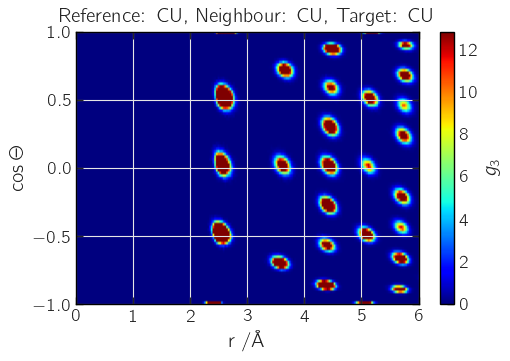

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3.5), constrained_layout=True)
map = ax.imshow(g3.distribution.T, 
                extent = [0, r_cut, -1, 1], # Note: we're giving the distribution matrix so we need to provide the scales.
                vmax   = vmax, 
                aspect = 'auto',
                cmap   = 'jet')     # choose your favourite colourmap
ax.set_title(f"Reference: {ref_atom.split(' ', 1)[1]}, Neighbour: {neigh_atom.split(' ', 1)[1]}, Target: {target_atom.split(' ', 1)[1]}")
ax.set_xlabel('r /\\AA')
ax.set_ylabel(r'$\cos \Theta$')
fig.colorbar(map,
             ticks = None,
             label = "$g_3$")

**Step 5.1 (optional):** Save the plots
- Save as png, pdf and/or svg
- Checks if any of the files exists

In [8]:
#-- Save? Change the names as needed and choose the format. Check if the file exists (any with the same base name).

savename   = f'g3_ref_{ref_atom.split(' ', 1)[1]}_neigh_{neigh_atom.split(' ', 1)[1]}_target_{target_atom.split(' ', 1)[1]}'
extensions = [".png", ".svg", ".pdf"]

#current_directory = os.getcwd()
#print(f"The current directory is: {current_directory}")

for ext in extensions:
    full_filename = f"{savename}{ext}"
    found_existing_file = False
    if os.path.exists(full_filename):
        found_existing_file = True
#        print(full_filename)
        existing_file_path = full_filename
        break 

if found_existing_file:
    print(f"\nError: The file \"{existing_file_path}\" already exists. Stopping execution.")
    sys.exit(1) 

#fig.savefig(savename+'.pdf',dpi=300)
fig.savefig(savename+'.png',dpi=300)
#fig.savefig(savename+'.svg')

## Tasks: 

Now that we know how to compute $g_3$, let's examine it further. Note that the above can be used to compute $g_3$ as a trajectory average or for a single frame by tuning the parameters.

1. Examine the $g_3$ plot above. Compare the distances and the angles of the nearest neighbors to the fcc structure of copper. Do they match? How to the 2nd and 3rd nearest neighbors? Check that:
  - Nearest neighbors: $a\frac{\sqrt{2}}{2}$
  - 2nd nn: $a$
  - 3rd nn: $a \frac{3}{2}$
  - 4th nn: $a \sqrt{2}$ 
2. Compute the traditional $g(r)$ for the same system and plot it. For that you need to import `rdf` from `MDAnalysis.analysis` and use `interRDF`. Again, check how well the peak positions correspond to the fcc structure of copper. 
3. Integrate over the angle in $g_3$ and plot the result as a function of distance ($r$). Compare the results to the direct calculation of $g(r)$ for the same selections by plotting together with the result from the previous problem. What are your conclusions? Explain the differences.